## GPR - 1dim Data / Gausssian / Sparse


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import arviz as az

from toygp import gp, kernels

In [2]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [3]:
jax.config.update('jax_enable_x64', True)

## Generate Keys

In [4]:
keys = jax.random.split(jax.random.PRNGKey(1), num=10)

## Generate Data

In [5]:
num_data = 500

X = 10 * jnp.sort(jax.random.uniform(keys[0], shape=(num_data,)))[:, None]
X.shape

(500, 1)

In [6]:
rho_true = 1.0
var_true = 3.0

kf = lambda x, y : var_true * kernels.rbf(x, y, rho_true)

v = dist.Normal(0, 1).sample(keys[1], sample_shape=(num_data,))
f_true = gp.exact(kf, X, v)

In [7]:
noise_true = 0.5

y = f_true + noise_true * dist.Normal(0, 1).sample(keys[2], sample_shape=(num_data,))

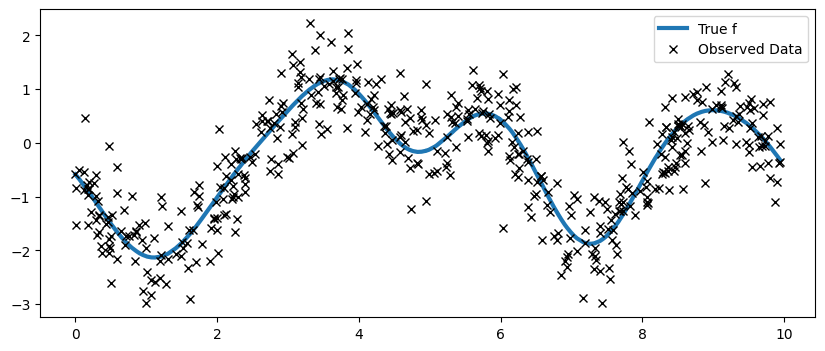

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(X, f_true, lw=3, label='True f')
plt.plot(X, y, 'kx', label='Observed Data')
plt.legend()
plt.show()

In [9]:
num_inducing_pts = 30

Xu = jnp.linspace(-10, 20, num_inducing_pts)
Xu = Xu[:, None]
Xu.shape

(30, 1)

## Define Model

In [10]:
def model(x, xu, y=None):

    num_data = x.shape[0]
    num_inducing_pts = xu.shape[0]

    #
    # Define Kernel Function
    #

    rho = numpyro.sample('rho', dist.Gamma(2, 1))
    var = numpyro.sample('var', dist.HalfNormal(10))
    kf = lambda x, y : var * kernels.rbf(x, y, rho)

    #
    # Define Gaussian Process
    #

    v = numpyro.sample('v', dist.Normal(0, 1), sample_shape=(num_inducing_pts,))
    f = gp.sparse(kf, x, xu, v)

    #
    # Set Observed Data
    #

    numpyro.deterministic('f', f)

    noise_sd = numpyro.sample('noise_sd', dist.HalfNormal(1))

    with numpyro.plate('data', size=num_data):

        numpyro.sample('obs', dist.Normal(f, noise_sd), obs=y)

## Inference

In [11]:
%%time

nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), x=X, xu=Xu, y=y)

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

CPU times: user 13min 10s, sys: 10min 23s, total: 23min 33s
Wall time: 4min 15s


## Check Samples

In [12]:
idata = az.from_numpyro(mcmc)

In [13]:
az.summary(idata, var_names=['var', 'rho', 'noise_sd'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
var,3.985,2.739,0.692,8.959,0.055,0.039,2334.0,3827.0,1.0
rho,1.129,0.109,0.928,1.340,0.002,0.001,2728.0,4579.0,1.0
noise_sd,0.515,0.017,0.484,0.546,0.000,0.000,15453.0,8434.0,1.0


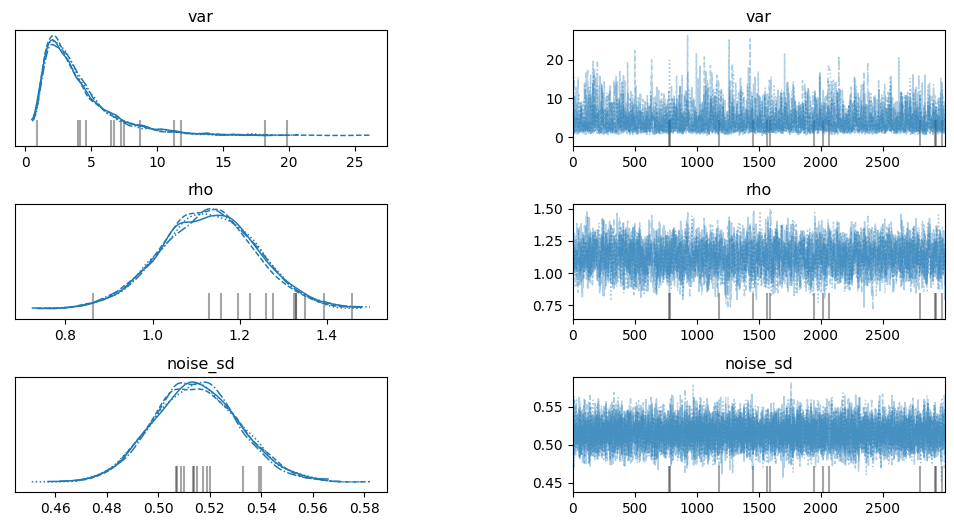

In [14]:
az.plot_trace(idata, var_names=['var', 'rho', 'noise_sd'])
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

## Posterior Predictive

In [15]:
X_new = jnp.linspace(-5, 15, 50)
X_new = X_new[:, None]

In [16]:
posterior_samples = mcmc.get_samples()

predictive = numpyro.infer.Predictive(model, posterior_samples)
predictive_samples = predictive(keys[5], x=X_new, xu=Xu)

In [17]:
f = predictive_samples['f'][:100, :].T

y_mean = np.mean(predictive_samples['obs'], axis=0)
y_perc = np.percentile(predictive_samples['obs'], [5.0, 95.0], axis=0)

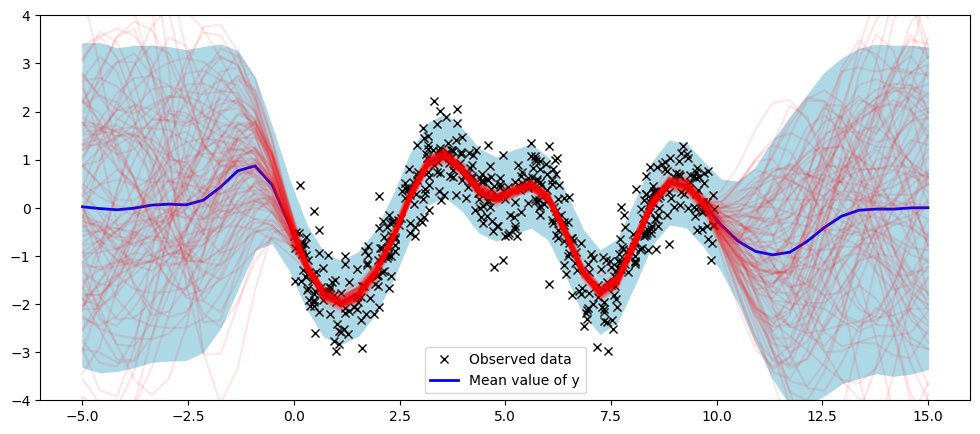

In [18]:
fig = plt.figure(figsize=(12, 5))

plt.plot(X, y, 'kx', label='Observed data')
plt.fill_between(X_new.flatten(), y_perc[0, :], y_perc[1, :], color='lightblue')
plt.plot(X_new.flatten(), y_mean, 'blue', ls='solid', lw=2.0, label='Mean value of y')
plt.plot(X_new.flatten(), f, 'red', alpha=0.1)
plt.ylim([-4, 4])
plt.legend()
plt.show()